In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import os
import sys
from datetime import date
import pathlib
import inspect
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..')) # qrc_surrogate
sys.path.append(module_path)
fig_path = f'{module_path}/figs'


from src.feedforward import QExtremeLearningMachine, CPolynomialFeedforward
from src.rewinding import QRewindingRC, QRewindingStatevectorRC
from src.data import DataSource

# Visualize the reactor data from Siemens

- 100 episodes



t1: 4 episodes with the same input. 1 with same y0.
t8: 7 episodes with the same input. 1 with same y0.
t17: 4 episodes with the same input. 1 with same y0.
t18: 4 episodes with the same input. 1 with same y0.
t22: 7 episodes with the same input. 1 with same y0.
t33: 4 episodes with the same input. 1 with same y0.
t39: 4 episodes with the same input. 1 with same y0.
t40: 4 episodes with the same input. 1 with same y0.
t53: 7 episodes with the same input. 1 with same y0.
t62: 4 episodes with the same input. 1 with same y0.
t65: 4 episodes with the same input. 1 with same y0.
t68: 7 episodes with the same input. 1 with same y0.
t69: 7 episodes with the same input. 1 with same y0.
t79: 7 episodes with the same input. 1 with same y0.
t84: 7 episodes with the same input. 1 with same y0.
1 episodes with the same input


/var/folders/ps/b_xnnqp54w7ftg23j0d14gtw0000gp/T/ipykernel_68603/1868897407.py:37: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(handles=[px, py], labels=['input x', 'desired output y'])


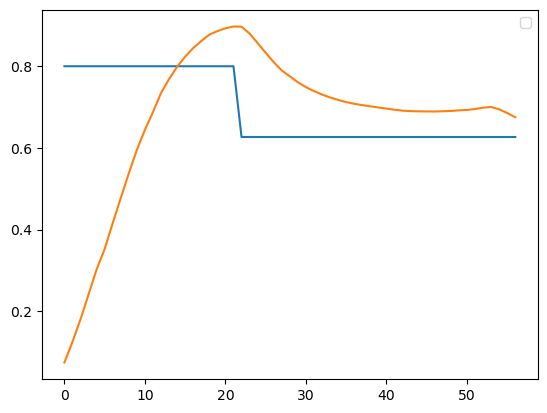

In [2]:
data = DataSource(xtype='reactor', nepisodes=85, rseed_data=0)

matchlen = 50

# find episodes with the same input
for target in range(len(data.xtrain)):
    xtrain = data.xtrain[target]
    ytrain = data.ytrain[target]
    ys_with_same_x = []
    ys_with_same_y0 = []
    for enum, x in enumerate(data.xtrain):
        if np.allclose(x[:matchlen], xtrain[:matchlen]):
            ys_with_same_x.append(data.ytrain[enum])
            if np.allclose(data.ytrain[enum][0], ytrain[0]): # same y0
                ys_with_same_y0.append(data.ytrain[enum])
    if len(ys_with_same_x) > 3:
        print(f't{target}: {len(ys_with_same_x)} episodes with the same input. {len(ys_with_same_y0)} with same y0.')


# plot those episodes
target = 16
xtrain = data.xtrain[target]
xlongest = xtrain
ys_with_same_x = []
for enum, x in enumerate(data.xtrain):
	if np.allclose(x[:matchlen], xtrain[:matchlen]):
		ys_with_same_x.append(data.ytrain[enum])
		if len(x) > len(xlongest):
			xlongest = x
print(f'{len(ys_with_same_x)} episodes with the same input')

colors = sns.color_palette()
fig = plt.figure()
px = plt.plot(xlongest, c=colors[0], label='input x')
for y in ys_with_same_x:
	py = plt.plot(y, c=colors[1], label='output y')
plt.legend(handles=[px, py], labels=['input x', 'desired output y'])
plt.show()

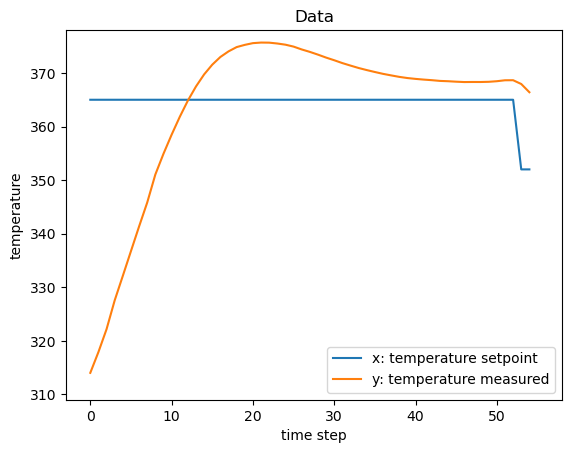

In [3]:
data = DataSource(xtype='reactor', ytype='reactor', nepisodes=5, xnorm='none', ynorm='none')

memory = 5
step = 6

cs = list(sns.color_palette())

plt.plot(data.xval[0], label='x: temperature setpoint', c=cs[0])
plt.plot(data.yval[0], label='y: temperature measured', c=cs[1])
plt.xlabel('time step')
plt.ylabel('temperature')
plt.xlim(-3, 58)
plt.ylim(309, 378)
plt.legend()
plt.title('Data')
plt.show()

# Access the reactor data

In [4]:
par_path = os.path.abspath(os.path.join(module_path, os.pardir)) # /quantum-reinforcement-learning/
rl_path = par_path + '/Code/quantum/RL_policy_sampling_using_QAOA/RL_QAOA'
sys.path.append(rl_path) 

from reactor_environment.mlp.data_generator import load_data, generate_model_data_mlp

In [5]:
data_path = rl_path + '/reactor_environment/data/sprungversuche.h5'

# load data 
df_traj, df_avg, df_std, total_trials = load_data(hdf_path=data_path)

# load full df
df = pd.read_hdf(data_path, key='df')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5894 entries, 1970-01-01 00:00:51.250000 to 1970-04-10 00:10:47.250000
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   T_jout ValueY        5894 non-null   float64
 1   T_R_setpoint ValueY  5894 non-null   float64
 2   m_M ValueY           5894 non-null   float64
 3   m_P ValueY           5894 non-null   float64
 4   UA ValueY            5894 non-null   float64
 5   Q_Reac ValueY        5894 non-null   float64
 6   m_M_setpoint ValueY  5894 non-null   float64
 7   T_R ValueY           5894 non-null   float64
 8   episode              5894 non-null   float64
dtypes: float64(9)
memory usage: 460.5 KB


In [7]:
df.min(axis=0)


T_jout ValueY          318.615753
T_R_setpoint ValueY    352.000000
m_M ValueY               0.000000
m_P ValueY              10.998088
UA ValueY                0.175687
Q_Reac ValueY            0.000000
m_M_setpoint ValueY      0.015000
T_R ValueY             308.949493
episode                  0.000000
dtype: float64